# Импортируем необходимые библиотеки

In [384]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import csv
import re
import numpy as np
import pickle
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from nltk import ngrams
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('snowball_data')
nltk.download('perluniprops')
nltk.download('universal_tagset')
nltk.download('stopwords')
nltk.download('nonbreaking_prefixes')
nltk.download('wordnet')

# Парсинг необходимых данных с сайта https://www.banki.ru/

In [61]:
texts = []
ratings = []
banks = []
datas = []

for i in range(1, 61): # На каждой странице по 25 отзывов. Нам нужно 1500. 1500/25=60
    response = requests.get(
        f'https://www.banki.ru/services/responses/list/product/debitcards/?page={i}&is_countable=on'
    )
    soup = bs(response.text, "html.parser")
    script_content = soup.find("script", type="application/ld+json").string
    while True:
        if script_content.find("reviewBody") == -1:
            break
        text = script_content[script_content.find("reviewBody")+13:script_content[script_content.find("reviewBody")+13:].find("\"")+script_content.find("reviewBody")+13]
        # Оставим только русские буквы (чтобы избавиться от закодированных знаков)
        cleaned_text = re.sub(r'[^А-Яа-яёЁ\.]', ' ', text)
        # Удаление лишних пробелов
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        texts.append(cleaned_text)
        
        ratings.append(script_content[script_content.find("ratingValue")+14:script_content[script_content.find("ratingValue")+14:].find("\"")+script_content.find("ratingValue")+14])
        
        banks.append(script_content[script_content.find("@type\":\"BankOrCreditUnion")+43:script_content[script_content.find("@type\":\"BankOrCreditUnion")+43:].find("\",")+script_content.find("@type\":\"BankOrCreditUnion")+43])
        
        datas.append(script_content[script_content.find("datePublished")+16:script_content[script_content.find("datePublished")+16:].find(" ")+script_content.find("datePublished")+16])

        script_content = script_content[script_content.find("reviewBody")+13:]

In [65]:
len(datas)

1500

In [297]:
df = pd.DataFrame({'Feedback': texts, 'Rating': ratings, 'Bank': banks, 'Publication_date': datas})

df.to_csv("my_data", index=False)

In [298]:
df

,Feedback,Rating,Bank,Publication_date
0,Хочу выразить благодарность сотруднику Валенти...,5,Газпромбанк,2023-09-20
1,В пешей доступности нет банкомата Уралсиба и я...,5,Газпромбанк,2023-09-19
2,Хочу выразить благодарность так как хорошее об...,1,Уралсиб,2023-09-19
3,Стал клиентом банка с марта года всё понравило...,4,Газпромбанк,2023-09-17
4,Интересовал вопрос по оформлению дебетовой кар...,5,Газпромбанк,2023-09-16
...,...,...,...,...
1495,. . г. обратился за консультацией в чат через ...,2,Альфа-Банк,2023-09-01
1496,Добрый день Решил получить дебетовую карту Аль...,5,Альфа-Банк,2023-09-01
1497,Добрый день. Хочу поблагодарить менеджера моск...,1,Альфа-Банк,2023-09-01
1498,Здравствуйте всем скажу вам так у меня есть мн...,5,Московский кредитный банк (МКБ),2023-09-01


# Анализ полученных данных

In [299]:
df['Publication_date'] = pd.to_datetime(df['Publication_date'])

In [300]:
bank_counts = df['Bank'].value_counts()

In [76]:
bank_counts

Тинькофф Банк                                      545
Альфа-Банк                                         544
Совкомбанк                                          80
Газпромбанк                                         67
Хоум Банк                                           48
Банк «Открытие»                                     34
ВТБ                                                 29
Россельхозбанк                                      27
Московский кредитный банк (МКБ)                     20
МТС Банк                                            18
Сбербанк                                            16
Банк ОЗОН                                           11
Ак Барс Банк                                         7
Уральский банк реконструкции и развития (УБРиР)      6
Русский Стандарт                                     6
Почта Банк                                           6
Банк Синара (СКБ-банк)                               5
Уралсиб                                              4
ОТП Банк  

Объединим банки, которые реже встречаются в таблице, в категорию "Другое"

In [301]:
df['Bank'] = df.apply(lambda row: row['Bank'] if bank_counts[row['Bank']] >= bank_counts.mean() else 'Другое', axis=1)

bank_counts = df['Bank'].value_counts()

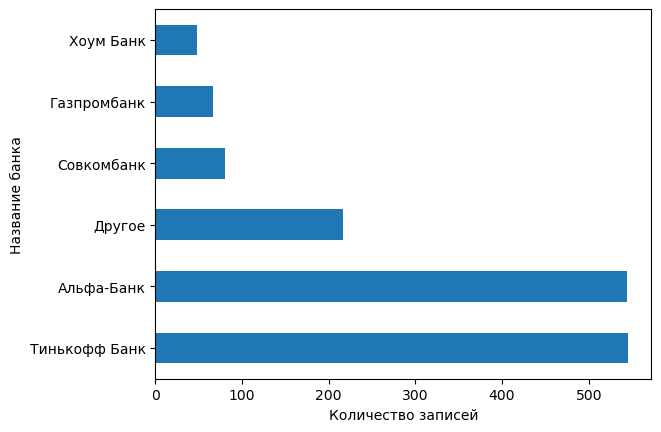

In [81]:
bank_counts.plot.barh()

plt.xlabel('Количество записей')
plt.ylabel('Название банка')

plt.show()

Из диаграммы можно сделать вывод, что больше всего отзывов было оставлено банку Тинькофф. Посмотрим, какие это отзывы.

In [302]:
df[df['Bank'] == "Тинькофф Банк"]["Rating"]

33      5
35      5
36      5
37      5
39      5
       ..
1484    5
1485    5
1486    5
1489    5
1491    5
Name: Rating, Length: 545, dtype: object

In [96]:
bank_rating_tink = df[df['Bank'] == "Тинькофф Банк"]["Rating"].value_counts()

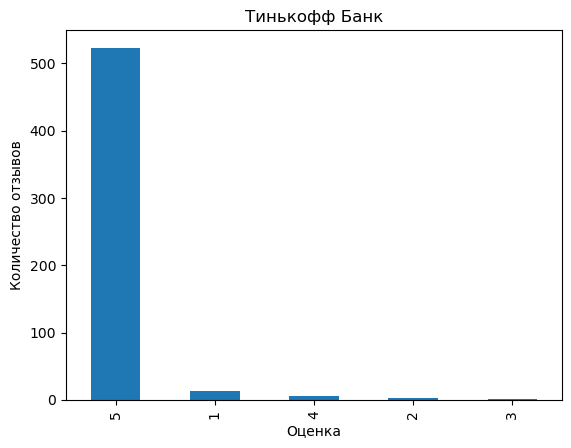

In [98]:
bank_rating_tink.plot(kind='bar', xlabel='Оценка', ylabel='Количество отзывов', title='Тинькофф Банк')
plt.show()

Наблюдаем явный дисбаланс классов. Скорее всего это будет отслеживаться и относительно всех данных в таблице. Построим диаграмму распределения оценок.

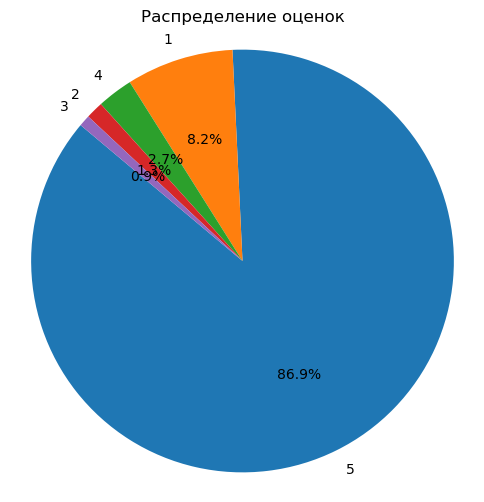

In [99]:
rating_counts = df['Rating'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение оценок')
plt.axis('equal') 

plt.show()

Наблюдаем явный дисбаланс классов. После предобработки воспользуемся случайным дублированием.

# Нормализация

In [304]:
sw = stopwords.words('russian')
punct = '!"#$%&()*\+,-\./:;<=>?@\[\]^_`{|}~„“«»†*\—/\-‘’'
snowball = SnowballStemmer("russian")
def good_words(text):
    #удаляем знаки препинания
    text = re.sub(r'[{}]'.format(re.escape(punct)), '', text)
    #токенизация
    text = word_tokenize(text)
    #Преобразование регистра
    text = [w.lower() for w in text if w != '']
    #удаляем стоп-слова
    text = [w for w in text if w not in sw]
    #стемминг
    text = [snowball.stem(w) for w in text]
    return ' '.join(set(text))

In [305]:
df['Data'] = df['Feedback'].apply(good_words)

In [306]:
df['Rating'] = df['Rating'].astype(int)

In [307]:
df

,Feedback,Rating,Bank,Publication_date,Data
0,Хочу выразить благодарность сотруднику Валенти...,5,Газпромбанк,2023-09-20,сотрудник так возможн хорош дальш подписк мил ...
1,В пешей доступности нет банкомата Уралсиба и я...,5,Газпромбанк,2023-09-19,сентябр втб дня отвратительн списан ошибочн со...
2,Хочу выразить благодарность так как хорошее об...,1,Другое,2023-09-19,корректн дня сотрудник сильн ряд хорош хот про...
3,Стал клиентом банка с марта года всё понравило...,4,Газпромбанк,2023-09-17,втб кэшбэк хорош кредитн плох убежа март месяц...
4,Интересовал вопрос по оформлению дебетовой кар...,5,Газпромбанк,2023-09-16,обязательн отсутств лин лишн подробн оформлен ...
...,...,...,...,...,...
1495,. . г. обратился за консультацией в чат через ...,2,Альфа-Банк,2023-09-01,абхаз возможн российск звезд александр границ ...
1496,Добрый день Решил получить дебетовую карту Аль...,5,Альфа-Банк,2023-09-01,эт происход росбанк соглас карт сказа мо добр ...
1497,Добрый день. Хочу поблагодарить менеджера моск...,1,Альфа-Банк,2023-09-01,сотрудник так анастас сформулирова приветлив к...
1498,Здравствуйте всем скажу вам так у меня есть мн...,5,Другое,2023-09-01,любим перевод эт ол пальц вежлив дел бог альфа...


Теперь займемся дисбалансом классов. Сделаем дубли классов, которых недостает.

In [343]:
class_1 = df[df['Rating'] == 1]
class_2 = df[df['Rating'] == 2]
class_3 = df[df['Rating'] == 3]
class_4 = df[df['Rating'] == 4]
class_5 = df[df['Rating'] == 5]

# Определяем размер, до которого нужно увеличить/уменьшить каждый класс
desired_class_size = 300

# Применяем случайное дублирование для каждого класса
class_1_resampled = resample(class_1, replace=True, n_samples=desired_class_size, random_state=42)
class_2_resampled = resample(class_2, replace=True, n_samples=desired_class_size, random_state=42)
class_3_resampled = resample(class_3, replace=True, n_samples=desired_class_size, random_state=42)
class_4_resampled = resample(class_4, replace=True, n_samples=desired_class_size, random_state=42)
class_5_resampled = resample(class_5, replace=True, n_samples=desired_class_size, random_state=42)

# Объединяем дублированные классы
resampled_data = pd.concat([class_1_resampled, class_2_resampled, class_3_resampled, class_4_resampled, class_5_resampled])

# Перемешиваем данные
resampled_data = resampled_data.sample(frac=1, random_state=42)

Проверим распределение классов теперь

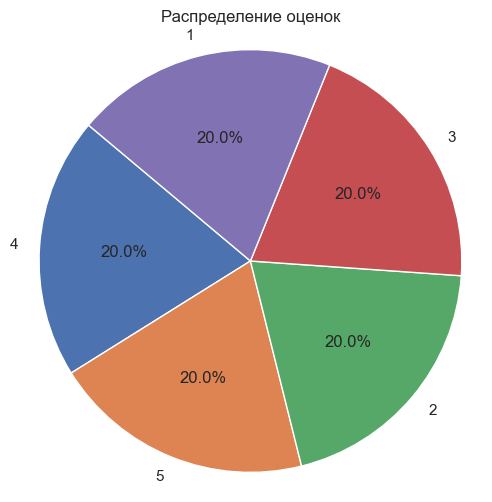

In [344]:
rating_counts = resampled_data['Rating'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение оценок')
plt.axis('equal')  

plt.show()

# Выбор метода машинного обучения

In [335]:
y = resampled_data['Rating']

In [336]:
vec = CountVectorizer()

X = vec.fit_transform(resampled_data["Data"])

In [337]:
X = X.toarray()

In [338]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [279]:
def text_to_vector(text, vector_size):
    # Создаем объект TF-IDF векторизатора с заданным размером
    vectorizer = TfidfVectorizer(max_features=vector_size, lowercase=True, stop_words='english')
    
    # Преобразуем текст в TF-IDF вектор
    tfidf_vector = vectorizer.fit_transform([text])
    
    # Преобразуем разреженную матрицу в плотный массив
    dense_vector = tfidf_vector.toarray()
    
    # Если размер вектора меньше заданного, дополним нулями
    if dense_vector.shape[1] < vector_size:
        padding = np.zeros((1, vector_size - dense_vector.shape[1]))
        dense_vector = np.hstack((dense_vector, padding))
    
    return dense_vector

# Пример использования:
text = good_words("банк тинькофф")
vector_size = 6967  # Размер вектора

result_vector = text_to_vector(text, vector_size)
print(result_vector)

[[0.70710678 0.70710678 0.         ... 0.         0.         0.        ]]


In [280]:
classifier.predict(result_vector)

array([3])

In [377]:
names = ["Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM",
         "Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="poly", degree=3, C=0.025),
    SVC(kernel="rbf", C=1, gamma=2),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB()]

In [378]:
scores = []
times = []

for name, clf in zip(names, classifiers):
    start_time = time.time()  # Запускаем счетчик времени
    clf.fit(X_train_tfidf, y_train)
    end_time = time.time()  # Останавливаем счетчик времени
    training_time = end_time - start_time  # Вычисляем время обучения
    print(f"{name} обучена")
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_pred, y_test)
    scores.append(score)
    times.append(training_time) 

Nearest_Neighbors обучена
Linear_SVM обучена
Polynomial_SVM обучена
RBF_SVM обучена
Gradient_Boosting обучена
Decision_Tree обучена
Extra_Trees обучена
Random_Forest обучена
Neural_Net обучена
AdaBoost обучена


In [380]:
scoring = pd.DataFrame()
scoring['name'] = names
scoring['score'] = scores
scoring['time'] = times
scoring.sort_values(by=["score"], ascending=False, inplace=True)
scoring

,name,score,time
2,Polynomial_SVM,0.925333,0.454140
6,Extra_Trees,0.898667,0.141827
0,Nearest_Neighbors,0.837333,0.003766
8,Neural_Net,0.834667,22.193392
4,Gradient_Boosting,0.746667,9.705486
1,Linear_SVM,0.632000,0.448356
7,Random_Forest,0.485333,0.229191
9,AdaBoost,0.376000,2.675862
5,Decision_Tree,0.330667,0.031255
3,RBF_SVM,0.157333,0.239539


In [382]:
model = SVC(kernel="poly", degree=3, C=0.025)
model.fit(X_train_tfidf, y_train)

SVC(C=0.025, kernel='poly')

# Сохранение модели

In [385]:
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)